In [1]:
import sys
sys.path.append('../')  
sys.path.append('../src')  


# import os
# import sys

# script_directory = os.path.dirname(os.path.realpath(__file__))
# project_root = os.path.join(script_directory, '..')
# sys.path.append(project_root)


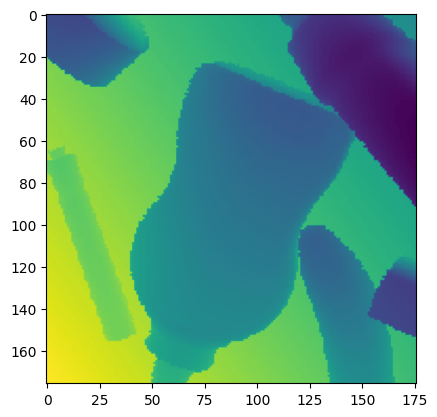

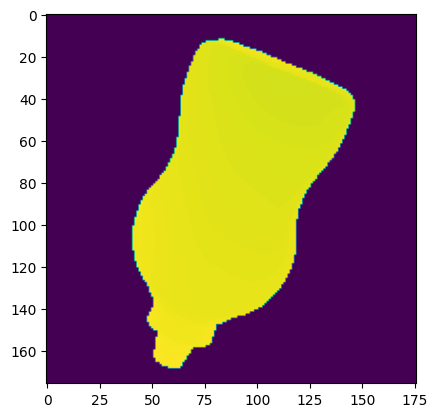

In [2]:
import torch
import torch.nn as nn

import cv2
import matplotlib.pyplot as plt
dpt = cv2.imread(r"C:\Users\dhruv\Desktop\680Final\data\mustard_bottle\validation_data_blender_DR\0000098depthB.png", cv2.IMREAD_UNCHANGED)
plt.imshow(dpt)
plt.figure()
dpt = cv2.imread(r"C:\Users\dhruv\Desktop\680Final\data\mustard_bottle\validation_data_blender_DR\0000098depthA.png", cv2.IMREAD_UNCHANGED)
plt.imshow(dpt)



In [3]:


class ruinDepth(nn.Module):
    def __init__(self):
        super().__init__()
        self.cn1 = nn.Conv2d(1, 3, kernel_size=(3,3), padding=1)
        self.rl1 = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm2d(3)

        self.cn2 = nn.Conv2d(3, 7, kernel_size=(3,3), padding=1)
        self.rl2 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm2d(7)

        self.cn3 = nn.Conv2d(7, 14, kernel_size=(3,3), padding=1)
        self.rl3 = nn.LeakyReLU()
        
        self.tcn1 = nn.ConvTranspose2d(14, 7, kernel_size=3, padding=1)
        self.rl4 = nn.Tanh()
        self.bn4 = nn.BatchNorm2d(7)

        self.tcn2 = nn.ConvTranspose2d(7, 3, kernel_size=3, padding=1)
        self.rl5 = nn.Tanh()
        self.bn5 = nn.BatchNorm2d(3)

        self.tcn3 = nn.ConvTranspose2d(3, 1, kernel_size=3, padding=1)
                
    
    def forward(self, x):
        x1 = self.bn1(self.rl1(self.cn1(x)))
        x2 = self.bn2(self.rl2(self.cn2(x1)))
        x = (self.rl3(self.cn3(x2)))

        x = self.bn4(self.rl4(self.tcn1(x))) + x2
        x = self.bn5(self.rl5(self.tcn2(x))) + x1
        out = self.tcn3(x)
        return out


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import glob
import os
import numpy as np

class SimDataset(Dataset):
    def __init__(self):
        root = r'C:\Users\dhruv\Desktop\680Final\data\0050'
        self.depthFiles =  sorted(glob.glob(os.path.join(root, 'depth/*.png')))
        self.depthFillFiles = sorted(glob.glob(os.path.join(root, 'depth_filled/*.png')))
    
    def __len__(self):
        return len(self.depthFiles)
    
    def __getitem__(self, idx):        
        dp = transforms.ToTensor()(np.float64(cv2.imread(self.depthFillFiles[idx], cv2.IMREAD_UNCHANGED)))
        tar = transforms.ToTensor()(np.float64(cv2.imread(self.depthFiles[idx], cv2.IMREAD_UNCHANGED)))
        return [dp, tar]


In [5]:
from typing import Any
import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

class train(pl.LightningModule):
    def __init__(self):
        super().__init__()
        loader = SimDataset()
        self.train_loader = torch.utils.data.DataLoader(loader, shuffle=True, batch_size=32)
        self.network = ruinDepth()
        self.tLoss = nn.MSELoss()

        self.loss = 0
        self.itr = 0

    def training_step(self, batch, batch_idx):
        images, targets = batch
        pred = self.network.forward(images.float())        
        loss = self.tLoss(pred, targets.float())

        self.loss+=loss; self.itr+=len(images)
        return {'loss': loss}
            
    def train_dataloader(self):
        return self.train_loader
    
    def on_train_batch_end(self, outputs: STEP_OUTPUT, batch: Any, batch_idx: int) -> None:
        self.log("loss", self.loss/self.itr)
        self.loss = 0
        self.itr = 0

    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: (1 - epoch / 30) ** 0.9),
            'interval': 'epoch'
        }
        return [optimizer], [scheduler]

# TensorBoard Logger
logger = pl.loggers.TensorBoardLogger('../logs/tb_logs', name='depthruiner')

# Checkpointing
checkpoint_callback = ModelCheckpoint(
    monitor='epoch',
    dirpath='checkpoints/',
    filename='my_model-{epoch:02d}-{loss:.2f}',
    save_top_k=3,
    mode='max',
)

# Learning Rate Monitor
lr_monitor = LearningRateMonitor(logging_interval='epoch')

torch.set_float32_matmul_precision('medium')
model = train()

# Trainer with logger, checkpoint, and LR monitor
trainer = pl.Trainer(
    devices=1, 
    accelerator="gpu", 
    max_epochs=30, 
    logger=logger,
    callbacks=[checkpoint_callback, lr_monitor]
)


c:\Users\dhruv\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | network | ruinDepth | 2.3 K 
1 | tLoss   | MSELoss   | 0     
--------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


232235.27799999996


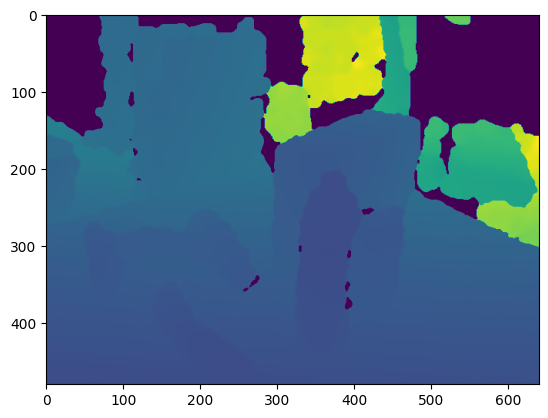

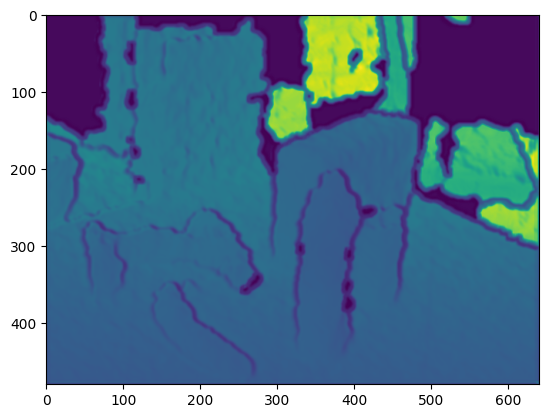

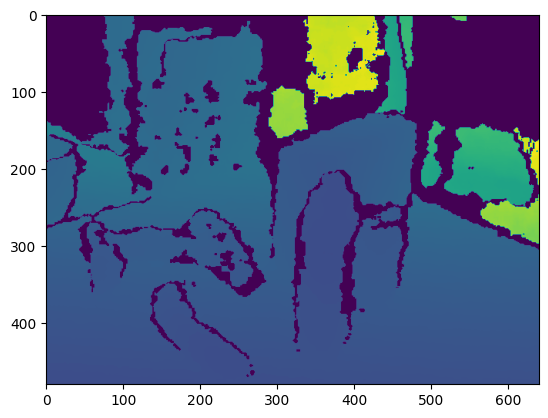

In [8]:
train_loader = torch.utils.data.DataLoader(SimDataset(), shuffle=False, batch_size=1)
for img, tar in train_loader:
    pred2 = img[0].cpu().detach().numpy().transpose(1,2,0)
    plt.imshow(pred2)
    plt.figure()
    pred = model.network.forward(img.float())
    pred2 = pred[0].cpu().detach().numpy().transpose(1,2,0)
    plt.imshow(pred2)
    plt.figure()
    pred = tar[0].cpu().detach().numpy().transpose(1,2,0)
    plt.imshow(pred)
    print(((pred - pred2)/1e3).round(3).sum())
    break